In [1]:
import jax
import flax
import optax
import numpy as np
import gymnasium as gym
from matplotlib import animation
import matplotlib.pyplot as plt
from jax import random, numpy as jnp

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('animation', html='jshtml')

In [2]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
obs, info = env.reset(seed=42)
obs, info

(array([ 0.0273956 , -0.00611216,  0.03585979,  0.0197368 ], dtype=float32),
 {})

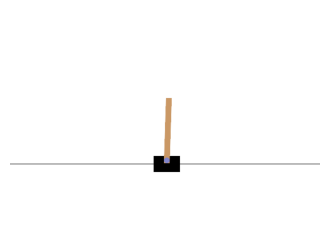

In [3]:
def show_env(env):
    img = env.render()
    plt.figure(figsize=(4,4))
    plt.imshow(img)
    plt.axis('off')

show_env(env)

In [4]:
action=1
obs,reward,done,truncated,info = env.step(action)
obs, reward, done, truncated

(array([ 0.02727336,  0.18847767,  0.03625453, -0.26141977], dtype=float32),
 1.0,
 False,
 False)

In [5]:
def basic_policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1

totals = []
for episode in range(500):
    episode_rewards = 0
    obs, info = env.reset(seed=episode)
    for step in range(200):
        action = basic_policy(obs)
        obs, reward, done, truncated, info = env.step(action)
        episode_rewards += reward
        if done or truncated:
            break
    totals.append(episode_rewards)

In [6]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

def show_one_episode(policy, n_max_steps=200, seed=42):
    frames = []
    env = gym.make("CartPole-v1", render_mode="rgb_array")
    np.random.seed(seed)
    obs, info = env.reset(seed=seed)
    for step in range(n_max_steps):
        frames.append(env.render())
        action = policy(obs)
        obs, reward, done, truncated, info = env.step(action)
        if done or truncated:
            break
    env.close()
    return plot_animation(frames)

show_one_episode(basic_policy)

In [7]:
import numpy as np

np.mean(totals), np.std(totals), min(totals), max(totals)

(41.698, 8.389445512070509, 24.0, 63.0)

In [49]:
from flax import linen as nn
from jax import random, numpy as jnp

class MLP(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(5)(x)
        x = nn.relu(x)
        x = nn.Dense(1)(x)
        return x

key, subkey = random.split(random.PRNGKey(0))
model = MLP()
params = model.init(subkey, obs[np.newaxis, :])
y = model.apply(params, obs[np.newaxis, :])

print('Initialized parameter shapes:\n', jax.tree_map(jnp.shape, params))
print('Output:\n', y)

Initialized parameter shapes:
 {'params': {'Dense_0': {'bias': (5,), 'kernel': (4, 5)}, 'Dense_1': {'bias': (1,), 'kernel': (5, 1)}}}
Output:
 [[0.04724307]]


In [53]:
@jax.jit
def loss_fn(params, obs, key):
    logits = model.apply(params, obs[np.newaxis])
    left_proba = nn.sigmoid(logits)
    action = random.uniform(key, (1,1)) > left_proba
    labels = jnp.array([[1.]]) - action
    return optax.sigmoid_binary_cross_entropy(logits, labels).mean(), action

def play_one_step(params, model, env, obs, key):
    grads, action = jax.grad(loss_fn, has_aux=True)(params, obs, key)
    obs, reward, done, truncated, _ = env.step(action.item())
    return obs, reward, done, truncated, grads

In [54]:
play_one_step(params, model, env, obs, key)

(array([ 0.13841096,  0.5369683 , -0.04535787, -0.6319416 ], dtype=float32),
 1.0,
 False,
 False,
 {'params': {'Dense_0': {'bias': Array([ 0.        ,  0.        , -0.29707745,  0.18983565,  0.        ],      dtype=float32),
    'kernel': Array([[ 0.        ,  0.        , -0.05615344,  0.03588264,  0.        ],
           [ 0.        ,  0.        , -0.11421002,  0.07298142,  0.        ],
           [-0.        , -0.        ,  0.06584532, -0.04207586, -0.        ],
           [-0.        , -0.        ,  0.15316193, -0.09787211, -0.        ]],      dtype=float32)},
   'Dense_1': {'bias': Array([0.528579], dtype=float32),
    'kernel': Array([[0.        ],
           [0.        ],
           [0.09426378],
           [0.31671634],
           [0.        ]], dtype=float32)}}})

In [55]:
def play_multiple_episodes(env, n_episodes, n_max_steps, model, params, key):
    all_rewards = []
    all_grads = []
    for _ in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs, _ = env.reset()
        for _ in range(n_max_steps):
            key, subkey = random.split(key)
            obs, reward, done, truncated, grads = play_one_step(
                params, model, env, obs, subkey
            )
            current_rewards.append(reward)
            current_grads.append(grads)
            if done or truncated: break
        all_rewards.append(current_rewards)
        all_grads.append(current_grads)
    return all_rewards, all_grads

In [56]:
def discount_rewards(rewards, discount_factor):
    discounted = np.array(rewards)
    for step in range(len(rewards)-2, -1, -1):
        discounted[step] += discounted[step + 1]* discount_factor
    return discounted

def discount_and_normalize_rewards(all_rewards, discount_factor):
    all_discounted_rewards = [discount_rewards(rewards, discount_factor)
                              for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    mean, std = flat_rewards.mean(), flat_rewards.std()
    return [(discounted_rewards-mean)/std 
            for discounted_rewards in all_discounted_rewards]

In [57]:
opt = optax.nadam(learning_rate=0.01)
opt_state = opt.init(params)
n_iterations = 150
n_episodes_per_update = 10
n_max_steps = 200
discount_factor = 0.95

In [58]:
for it in range(n_iterations):
    all_rewards, all_grads = play_multiple_episodes(
        env, n_episodes_per_update, n_max_steps, model, params, key
    )

    total_rewards = sum(map(sum, all_rewards))
    print(f"\rIteration: {it + 1}/{n_iterations},"
          f" mean rewards: {total_rewards / n_episodes_per_update:.1f}", end="")

    all_final_rewards = discount_and_normalize_rewards(all_rewards, discount_factor)
    all_mean_grads = []
    params_arr, params_info = jax.tree_util.tree_flatten(params)
    for var_index in range(len(params_arr)):
        scaled_grads = jnp.array([reward * jax.tree_util.tree_leaves(all_grads[episode][step])[var_index]
                  for episode, rewards in enumerate(all_final_rewards)
                  for step, reward in enumerate(rewards)])
        mean_grads = jnp.mean(scaled_grads, axis=0)
        all_mean_grads.append(mean_grads)
    
    grads = jax.tree_util.tree_unflatten(params_info, all_mean_grads)
    #print(grads)
    updates, opt_state = opt.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)


Iteration: 3/150, mean rewards: 21.0

KeyboardInterrupt: 

In [35]:
def pg_policy(obs):
    left_proba = model.apply(params, obs[np.newaxis, :])
    return (np.random.rand() > left_proba).item()

show_one_episode(pg_policy)

In [36]:
rewards, _  = play_multiple_episodes(env, 5, 200, model, params, key)

[sum(r) for r in rewards] 

[200.0, 200.0, 200.0, 200.0, 145.0]